Utilizar con el bitstream `Top_wrapper_xor2.xsa`

In [13]:
from udma import UDMA_CLASS as udma
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
from nistrng import *

In [14]:
#Load Comblock
cb=udma("192.168.1.10", 7)
cb.connect()
cb.log(0)

[(5,), 0]

In [15]:
def config(div = 4, rule= 1771476585, fb = 6, sync= 0, test = 0, clear= 0, set=0):
    cb.log(1)
    cb.write_reg(6, 0)
    #Reduce clock frequency by factor of 8
    cb.write_reg(11, 1)
    cb.write_reg(10, div)
    cb.write_reg(11, 0)
    # reset cell
    cb.write_reg(5, 1)
    # clear ofifo
    cb.write_reg(21, 1)
    cb.write_reg(21, 0)
    # clear ififo
    cb.write_reg(17, 1)
    cb.write_reg(17, 0)
    # clear fifo through loopback reg
    cb.write_reg(7, 1)
    cb.write_reg(7, 0)
    #test disable
    cb.write_reg(9, test)
    # write rule
    cb.write_reg(8, rule)
    # set fb_type
    cb.write_reg(0, fb)
    # set sync
    cb.write_reg(1, sync)
    # clear cell
    cb.write_reg(2, clear)
    # set cell
    cb.write_reg(3, set)
    # reset cell
    cb.write_reg(5, 0)
    # fifo write enable
    cb.write_reg(6, 1)
    # disable log
    cb.log(0)


4096
[0 1 1 ... 1 0 0]


(array([808369.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 791631.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

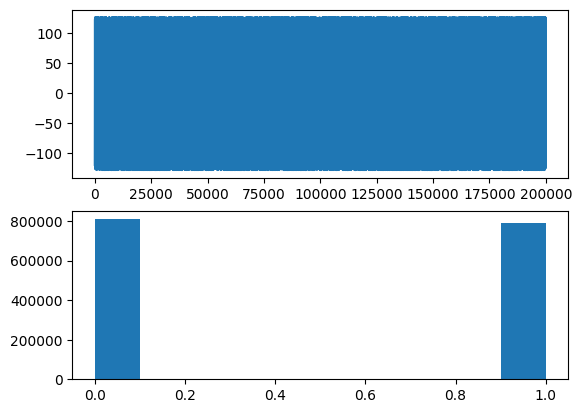

In [16]:
#Set up automatas
config(rule= 1771476585, fb = 5, div=20)
# config(rule=1771476585, fb=5, div=20, xor_en=0)

#Check if FIFO is empty
print(cb.read_reg(34)[1][0]>>16)


#Read fifo
N=int(50000)
b=cb.write_reg(6,1)
sleep(5)
data=[]
while len(data)<N:
    a=cb.read_fifo(1000)
    data.extend(a[1])
cb.write_reg(6,0)

dsplit=[]
for d in data:
    dsplit.append(d&0xff)
    dsplit.append((d>>8)&0xff)
    dsplit.append((d>>16)&0xff)
    dsplit.append((d>>24)&0xff)

sequence: np.ndarray = np.array(dsplit).astype(np.int8)

fig, ax=plt.subplots(3)
ax[0].plot(sequence)
ax[1].hist(sequence)
#Packing sequence and checking balance
binary_sequence: np.ndarray = pack_sequence(sequence)
print(binary_sequence)
ax[2].hist(binary_sequence)

In [17]:
# seq1=sequence[:int(len(sequence)/2)]
# seq2=np.bitwise_not(sequence[int(len(sequence)/2):])
# sequence=seq1+seq2
# fig, ax=plt.subplots(3)
# ax[0].plot(sequence)
# ax[1].hist(sequence)
# #Packing sequence and checking balance
# binary_sequence: np.ndarray = pack_sequence(sequence)
# print(binary_sequence)
# ax[2].hist(binary_sequence)

In [18]:
# Random number generated sequence
# sequence: np.ndarray = np.random.randint(-128, 128, 1000, dtype=int)

# Packing sequence into binary
# binary_sequence: np.ndarray = pack_sequence(sequence)
# Print sequence
print("CAA Generated sequence generated by np:")
print(sequence)
print("Random sequence generated by np encoded in 8-bit signed format:")
print(binary_sequence)
print("Original sequence taken back by unpacking (to check the correctness of packing process:")
print(unpack_sequence(binary_sequence))
# Check the eligibility of the test and generate an eligible battery from the default NIST-sp800-22r1a battery
eligible_battery: dict = check_eligibility_all_battery(binary_sequence, SP800_22R1A_BATTERY)
# Print the eligible tests
print("Eligible test from NIST-SP800-22r1a:")
for name in eligible_battery.keys():
    print("-" + name)
# Test the sequence on the eligible tests
results = run_all_battery(binary_sequence, eligible_battery, False)
# Print results one by one
print("Test results:")
for result, elapsed_time in results:
    if result.passed:
        print("- PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
    else:
        print("- FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

CAA Generated sequence generated by np:
[122  21 -30 ... -84 111  68]
Random sequence generated by np encoded in 8-bit signed format:
[0 1 1 ... 1 0 0]
Original sequence taken back by unpacking (to check the correctness of packing process:
[122  21 -30 ... -84 111  68]
Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-longest_run_ones_in_a_block
-binary_matrix_rank
-dft
-non_overlapping_template_matching
-overlapping_template_matching
-maurers_universal
-linear_complexity
-serial
-approximate_entropy
-cumulative sums
-random_excursion
-random_excursion_variant
Test results:
- FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
- FAILED - score: 0.0 - Frequency Within Block - elapsed time: 1 ms
- FAILED - score: 0.0 - Longest Run Ones In A Block - elapsed time: 1083 ms
- FAILED - score: 0.0 - Binary Matrix Rank - elapsed time: 6495 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 125 ms
- PASSED - score: 1.0 - Non Overlapping Template Matching - 